Here we want to test whether we can use ML methods to identify the true CBs, inspired by the DropEst BioRxiv manuscript.
Many of the features can be obtained from alevin using the --dumpfeatures option which provides files with
* \# reads per CB (frequency.txt)
* \# mapped reads (MappedUmi.txt)

We can also obtain the # reads per CB post deduplication by summing up the counts in the CB/quant.sf file. From these three metrics we can obtain 
* Fraction of non-genic reads
* Duplication rate

We are also going to use
* Fraction of Mt reads (This was used in DropEst as a hard threshold. We want to see whether it's useful to include in ML)
* Some measure(s) of expression distribution
* Mean CB quality (This is currently unavailable - need to ask Avi to dump this too)
* Max correlation with true cells


In [128]:
import glob
import os
import pandas as pd
import numpy as np
import sqlite3
import scipy
from datetime import datetime
import CGAT.IOTools as IOTools

from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB


%load_ext rpy2.ipython
%matplotlib inline  

In [2]:
# glob.glob very slow with [...]/cell/*/quant.sf for some reason. We know each subdirectory will contain a quant.sf file
quant_files = [os.path.join(x, "quant.sf") for x in glob.glob("../whitelisting/alevin_run/test/alevin/cell/*")]
print(len(quant_files))

5887


In [3]:
CB_counts = {}
CB_mapped_counts = {}

true_cells = set()
false_cells = set()
ambiguous_cells = set()

with IOTools.openFile("../whitelisting/alevin_run/test/alevin/frequency.txt") as inf:
    for ix, line in enumerate(inf):
        cell, count = line.strip().split("\t")
        CB_counts[cell] = int(count)
        if ix < 2446: # top 2446 cells
            true_cells.add(cell)
        elif ix < 4892:
            ambiguous_cells.add(cell)
        else:
            false_cells.add(cell)
            
with IOTools.openFile("../whitelisting/alevin_run/test/alevin/MappedUmi.txt") as inf:
    for line in inf:
        cell, count = line.strip().split("\t")
        CB_mapped_counts[cell] = int(count)
        
        


In [4]:
print((5892-1000)/2)

2446.0


In [5]:
print(len(CB_counts))
print(len(CB_mapped_counts))

5892
5892


In [6]:
dedup_counts = pd.read_table(quant_files[0], sep="\t", usecols=[0,2], index_col=0)
sample_name = quant_files[0].split("/")[-2]
dedup_counts.columns = [sample_name]
print(dedup_counts.sort_values('GCTTCCATCTCCTATA').tail())
print(CB_counts['GCTTCCATCTCCTATA'])
print(CB_mapped_counts['GCTTCCATCTCCTATA'])
print(dedup_counts.sum(axis=0))
gene_n = len(dedup_counts.index)

                 GCTTCCATCTCCTATA
Name                             
ENST00000274065           309.123
ENST00000391857           311.881
ENST00000343262           364.084
ENST00000534336           437.000
ENST00000311549           481.674
94154
64671
GCTTCCATCTCCTATA    15684.999877
dtype: float64


In [7]:
CB_dedup_counts = {}

print(dedup_counts.shape)

no_quant = set()
n = 0
for infile in quant_files[1:]:
    if n % 500 == 0:
        print(n, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    n+=1

    sample_name = infile.split("/")[-2]
    tmp_counts = np.zeros(gene_n)
    
    if not os.path.exists(infile):
        no_quant.add(sample_name)
        continue
        
    with IOTools.openFile(infile, "r") as inf:
        header = next(inf)
        for ix, line in enumerate(inf):
            tmp_counts[ix] = line.strip().split("\t")[-1]
    dedup_counts[sample_name] = tmp_counts

print(n, datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print(dedup_counts.shape)
print(dedup_counts.head())
    
    


(197357, 1)
0 2017-12-21 15:53:02
500 2017-12-21 15:57:33
1000 2017-12-21 16:02:23
1500 2017-12-21 16:07:13
2000 2017-12-21 16:12:19
2500 2017-12-21 16:17:35
3000 2017-12-21 16:22:37
3500 2017-12-21 16:27:40
4000 2017-12-21 16:32:24
4500 2017-12-21 16:36:27
5000 2017-12-21 16:40:31
5500 2017-12-21 16:44:39
5886 2017-12-21 16:47:57
(197357, 5886)
                 GCTTCCATCTCCTATA  GGCTGGTCAGATTGCT  GCATGTACAGCTGCTG  \
Name                                                                    
ENST00000456328               0.0               0.0               0.0   
ENST00000450305               0.0               0.0               0.0   
ENST00000488147               0.0               0.0               0.0   
ENST00000619216               0.0               0.0               0.0   
ENST00000473358               0.0               0.0               0.0   

                 CATATTCGTGCCTTGG  TTCGGTCGTCGGATCC  CAGCAGCAGAATCTCC  \
Name                                                               

In [8]:
print([dedup_counts.iloc[0:10,0:10].sum(axis=1)>0])

[Name
ENST00000456328    False
ENST00000450305    False
ENST00000488147    False
ENST00000619216    False
ENST00000473358    False
ENST00000469289    False
ENST00000607096    False
ENST00000417324    False
ENST00000461467    False
ENST00000606857    False
dtype: bool]


In [9]:
print(dedup_counts.shape)
keep_transcript = dedup_counts.sum(axis=1)>0
print(sum(keep_transcript))
dedup_counts = dedup_counts.loc[keep_transcript,:]
print(dedup_counts.shape)

(197357, 5886)
143423
(143423, 5886)


In [10]:
print(no_quant)
print(len(CB_mapped_counts))
print(dedup_counts.shape)
dedup_rate = {}
alignment_rate = {}
for cell in CB_mapped_counts:
    if cell not in dedup_counts.columns:
        if cell not in no_quant:
            print("cell no in dedup counts dataframe but not recorded as having no quant data! - %s" % cell)
    else:
        alignment_rate[cell] =  CB_mapped_counts[cell] / CB_counts[cell]       
        
        sum_deduped = sum(dedup_counts[cell])
        dedup_rate[cell] = 1-(sum_deduped/CB_mapped_counts[cell])
        
    

{'GAACTGCGATGGGCAT'}
5892
(143423, 5886)
cell no in dedup counts dataframe but not recorded as having no quant data! - GAAACCAATCCGCGGC
cell no in dedup counts dataframe but not recorded as having no quant data! - GATTGCGTACCCGACG
cell no in dedup counts dataframe but not recorded as having no quant data! - GGGGAAGGACGTCAAT
cell no in dedup counts dataframe but not recorded as having no quant data! - GTACGGGGAAGGACGT
cell no in dedup counts dataframe but not recorded as having no quant data! - GGCGTACGGGGAAGGA


We need to identify the mitochondrial genes. We can do this using the transcriptome fasta against which the salmon index was built

In [11]:
mt_genes = set()
with IOTools.openFile("../whitelisting/reference/transcriptome.fa", "r") as inf:
    for line in inf:
        if line.startswith(">"):
            gene, coordinates = line.strip().split(" ")
            contig = coordinates.split(":")[0]
            if contig == 'chrM':
                mt_genes.add(gene[1:])

print(len(mt_genes))


37


In [12]:
mt_fraction = {}
mt_counts = dedup_counts.loc[mt_genes]
mt_fraction = mt_counts.sum(axis=0)/dedup_counts.sum(axis=0)
    

In [13]:
dbh = sqlite3.connect("/home/FILESERVER5/proteomics/tss38/ifs/mirror/annotations/hg38_ensembl87/csvdb")
select = dbh.execute("select distinct transcript_id, gene_id from transcript_info")
gene2transcript = {x:y for x,y in select}


In [14]:
gene_dedup_counts = dedup_counts.groupby([gene2transcript[x] for x in dedup_counts.index]).aggregate(np.sum)

In [15]:
ratio_mean_max = {}
over_mean = {}
for cell in alignment_rate:
    expression_values = [x for x in gene_dedup_counts[cell] if x>0]
    mean_expression = np.mean(expression_values)
    ratio_mean_max[cell] = mean_expression / np.max(expression_values)  
    over_mean[cell] = sum([x > mean_expression for x in expression_values]) / len(expression_values)

Get the correlation with the true cells, excl. correlation with itself of course! We'll pre-compute ranks to save time.

In [31]:
keep_genes = gene_dedup_counts.sum(axis=1).sort_values(ascending=False)[0:1000].index
top_1000_genes_dedup_counts = gene_dedup_counts.ix[keep_genes]
true_cell_arrays = {}
for cell in true_cells:
    true_cell_arrays[cell] = scipy.stats.rankdata(top_1000_genes_dedup_counts[cell])

In [17]:
print(top_1000_genes_dedup_counts.columns.tolist()[0:10])
print(list(true_cells)[0:10])

['GCTTCCATCTCCTATA', 'GGCTGGTCAGATTGCT', 'GCATGTACAGCTGCTG', 'CATATTCGTGCCTTGG', 'TTCGGTCGTCGGATCC', 'CAGCAGCAGAATCTCC', 'GACGCGTCACGTAAGG', 'GGCCGATAGTCCTCCT', 'TGAGAGGGTGTTTGTG', 'CTCGAGGGTCGCCATG']
['ACATCAGCAGCTGTAT', 'ATCATCTCAGTACACT', 'CTCACACAGCCCGAAA', 'CCGTGGAAGTAGGCCA', 'TAAACCGGTCTCACCT', 'CGGAGCTTCTACCTGC', 'GAACATCCACAAGCCC', 'TTCTACAGTGACTCAT', 'ACATACGCAGCTGCAC', 'TTGGCAACATACAGCT']


In [37]:
start = datetime.now()
print("processed 0 cells %s" % (datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
n = 0
cor_with_true = {} # best correlation
for cell in top_1000_genes_dedup_counts.columns:
    #print(cell)
    cell_exp_array = scipy.stats.rankdata(top_1000_genes_dedup_counts[cell])
    
    max_cor = -1
    for true_cell in true_cells:
        if true_cell == cell: # skip correlation with itself!
            continue
        cor = scipy.stats.pearsonr(cell_exp_array, true_cell_arrays[true_cell])[0]
        if cor > max_cor:
            max_cor = cor
        if cor == 1:
            print(true_cell, cell, true_cell_arrays[true_cell][0:10], cell_exp_array[0:10])
            break
    
    cor_with_true[cell] = max_cor
        
    n+=1
    print("processed %i cells. Predicted finish: %s\r" % (
        n, (start + (datetime.now()-start)*(5586/n)).strftime('%Y-%m-%d %H:%M:%S')), end="")
    

print("processed all %i cells %s" % (n, datetime.now().strftime('%Y-%m-%d %H:%M:%S')))

processed 0 cells 2017-12-21 17:11:39


/home/FILESERVER5/proteomics/tss38/devel/py36-v1/conda-install/envs/py36-v1/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


processed all 5886 cells 2017-12-21 17:22:24-12-21 17:21:52


In [96]:
features = pd.DataFrame([alignment_rate, dedup_rate, mt_fraction,
                         ratio_mean_max, over_mean, cor_with_true]).transpose()
features.columns = ["alignment", "duplication", "mt", "mean_max", "over_mean", "cor"]
features["cb_counts"] = [CB_counts[cell] for cell in features.index]

In [136]:
def getCellType(cb, true_cells, false_cells, ambiguous_cells):
    if cb in true_cells:
        return("true")
    elif cb in false_cells:
        return("false")
    elif cb in ambiguous_cells:
        return("ambiguous")
    else:
        raise ValueError("unknown cell type!")

features['cell_type'] = [getCellType(x, true_cells, false_cells, ambiguous_cells) for x in features.index]

print(features.head())

                  alignment  duplication        mt  mean_max  over_mean  \
AAAAAAAAAAAAAAAA   0.266864     0.662971  0.000000  0.185365   0.719512   
AAACCTGAGAAGGCCT   0.749062     0.792919  0.033361  0.026521   0.189883   
AAACCTGAGACAGACC   0.779763     0.775237  0.025761  0.026779   0.146705   
AAACCTGAGATAGTCA   0.762442     0.801038  0.043742  0.025174   0.185738   
AAACCTGAGCGCCTCA   0.659901     0.770617  0.015860  0.025621   0.165097   

                       cor  cb_counts  cell_type   pred      prob  
AAAAAAAAAAAAAAAA  0.137682       1690      false  false  0.000000  
AAACCTGAGAAGGCCT  0.583743      28772  ambiguous   true  0.994941  
AAACCTGAGACAGACC  0.619712      49583  ambiguous   true  1.000000  
AAACCTGAGATAGTCA  0.540716      25017  ambiguous  false  0.024561  
AAACCTGAGCGCCTCA  0.577791      46654  ambiguous   true  1.000000  


In [137]:
use_metrics = ["alignment", "duplication", "mt", "mean_max", "over_mean", "cor"]

In [138]:
# Split-out validation dataset
ml_df = features[[x in ["true", "false"] for x in features['cell_type']]]
     
X = ml_df.loc[:,use_metrics].values
Y = ml_df['cell_type'].values
validation_size = 0.20
seed = 0
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(
    X, Y, test_size=validation_size, random_state=seed)

scoring = 'accuracy'


In [139]:
def predictCellType(features, ml):
    X_full = features.loc[:,use_metrics].values
    predictions = ml.predict(X_full)
    probs = [x[1] for x in ml.predict_proba(X_full)]
    print(features['cell_type'].value_counts())
    print(confusion_matrix(features['cell_type'], predictions))
    print("\n\n")
    return(predictions, probs)

In [140]:
def testNBPriors(prior_values=False):
    if prior_values:
        ml = GaussianNB(prior_values)
    else:
        ml = GaussianNB()
    ml.fit(X_train, Y_train)
    predictions = ml.predict(X_validation)
    x = predictCellType(features[[x not in ["true", "false"] for x in features['cell_type']]], ml)
    predictions, probs = predictCellType(features, ml)
    features['pred'] = predictions
    features['prob'] = probs
    return(features)

In [141]:
cell_type_counts = features['cell_type'].value_counts()
prob_true = cell_type_counts['true'] / (cell_type_counts['true'] + cell_type_counts['false'])
#print(cell_type_counts, "\n")

df_NB_unequal1 = testNBPriors([prob_true, 1-prob_true])
df_NB = testNBPriors()

ambiguous    2446
Name: cell_type, dtype: int64
[[   0  645 1801]
 [   0    0    0]
 [   0    0    0]]



ambiguous    2446
true         2446
false         994
Name: cell_type, dtype: int64
[[   0  645 1801]
 [   0  994    0]
 [   0    4 2442]]



ambiguous    2446
Name: cell_type, dtype: int64
[[   0  623 1823]
 [   0    0    0]
 [   0    0    0]]



ambiguous    2446
true         2446
false         994
Name: cell_type, dtype: int64
[[   0  623 1823]
 [   0  994    0]
 [   0    4 2442]]





In [142]:
ml = GaussianNB()#[prob_true, 1-prob_true])
ml.fit(X_train, Y_train)
predictions = ml.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

1.0
[[190   0]
 [  0 498]]
             precision    recall  f1-score   support

      false       1.00      1.00      1.00       190
       true       1.00      1.00      1.00       498

avg / total       1.00      1.00      1.00       688



In [143]:
predictions, probs = predictCellType(features, ml)
features['pred'] = predictions
features['prob'] = probs

ambiguous    2446
true         2446
false         994
Name: cell_type, dtype: int64
[[   0  623 1823]
 [   0  994    0]
 [   0    4 2442]]





In [144]:
%%R 
library(ggplot2)

my_theme <- theme_bw() + theme(text=element_text(size=20), panel.grid=element_blank(), aspect.ratio=1)

makePCA <- function(df, use_metrics){
    pca <- prcomp(t(df[,match(use_metrics,colnames(df))]))
    projections <- data.frame(pca$rotation)
    projections <- merge(projections, df, by="row.names")
    return(projections)
}


printPCA <- function(projections, x="PC1", y="PC2", lim=T, colour_by=F, facet_by=F, facet_by_y=F){
    p <- ggplot(projections, aes_string(x, y)) + geom_point() + my_theme
    
    if(lim){
    p <- p + xlim(c(quantile(projections[[x]], c(0.01, 0.99)))) +
        ylim(c(quantile(projections[[y]], c(0.01, 0.99))))
    }
    
    if(!missing(colour_by)){
        p <- p + aes_string(colour=colour_by)
    }
    
    if(!missing(facet_by)){
        if(!missing(facet_by_y)){
            p <- p  + facet_wrap(as.formula(sprintf("%s~%s", facet_by, facet_by_y)))
        }
        else{
            p <- p + facet_wrap(as.formula(sprintf("~%s", facet_by)))
        }
    }

    print(p)
}

printPCs <- function(projections, ...){
    printPCA(projections, ...)
    printPCA(projections, "PC3", "PC4", ...)
    printPCA(projections, "PC5", "PC6", ...)    
}


In [145]:
%%R -i features -i use_metrics

projections <- makePCA(features, use_metrics)

In [146]:
%%R
print(head(features))

                 alignment duplication         mt   mean_max over_mean
AAAAAAAAAAAAAAAA 0.2668639   0.6629712 0.00000000 0.18536550 0.7195122
AAACCTGAGAAGGCCT 0.7490616   0.7929195 0.03336072 0.02652059 0.1898833
AAACCTGAGACAGACC 0.7797632   0.7752373 0.02576094 0.02677858 0.1467049
AAACCTGAGATAGTCA 0.7624415   0.8010381 0.04374177 0.02517413 0.1857380
AAACCTGAGCGCCTCA 0.6599005   0.7706174 0.01585953 0.02562057 0.1650970
AAACCTGAGCTGGAAC 0.9086758   0.8341708 0.37349694 0.10413746 0.2580645
                       cor cb_counts cell_type  pred      prob
AAAAAAAAAAAAAAAA 0.1376822      1690     false false 0.0000000
AAACCTGAGAAGGCCT 0.5837433     28772 ambiguous  true 0.9991479
AAACCTGAGACAGACC 0.6197123     49583 ambiguous  true 1.0000000
AAACCTGAGATAGTCA 0.5407156     25017 ambiguous false 0.1305281
AAACCTGAGCGCCTCA 0.5777911     46654 ambiguous  true 0.9999999
AAACCTGAGCTGGAAC 0.3064613      1971     false false 0.0000000


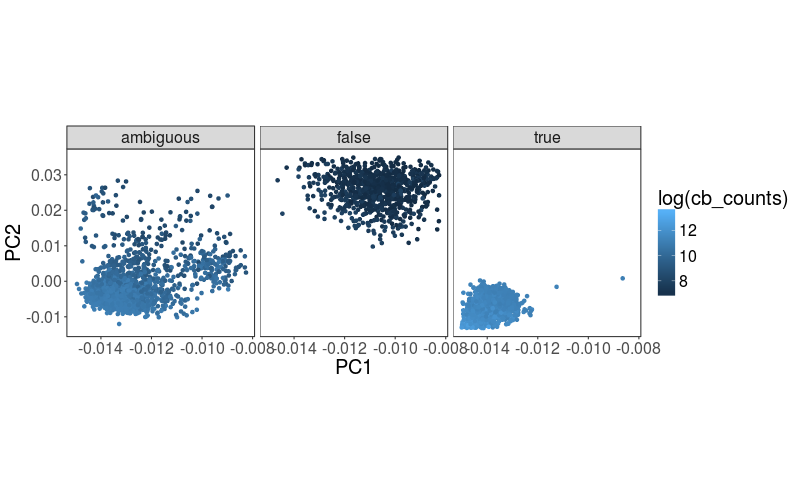

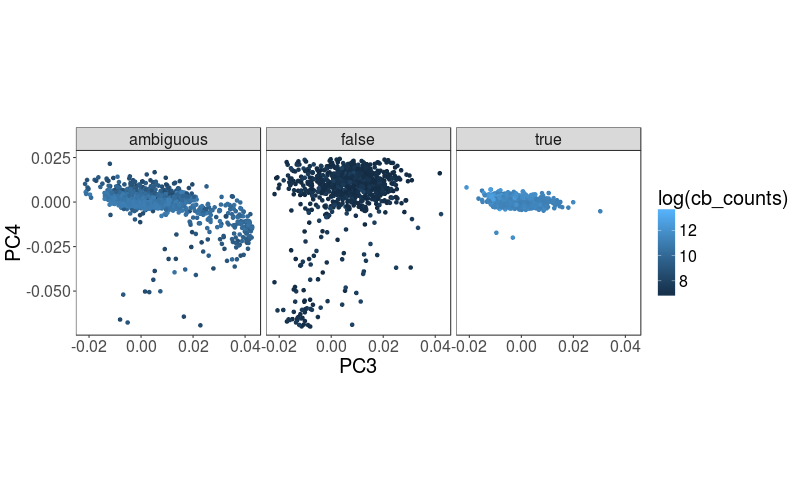

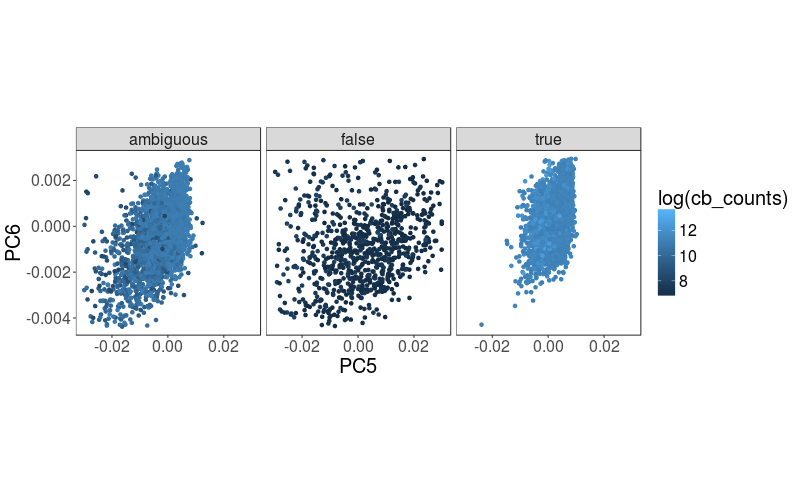

In [147]:
%%R -w 800 -h 500
printPCs(projections, colour_by="log(cb_counts)", facet_by="cell_type")

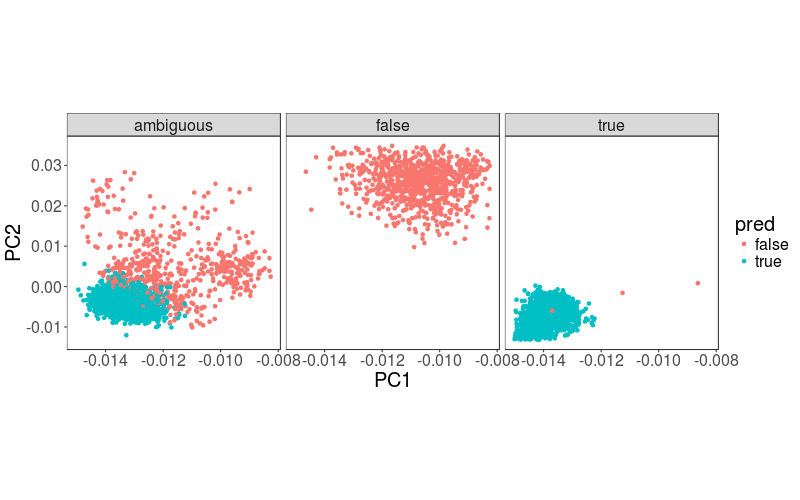

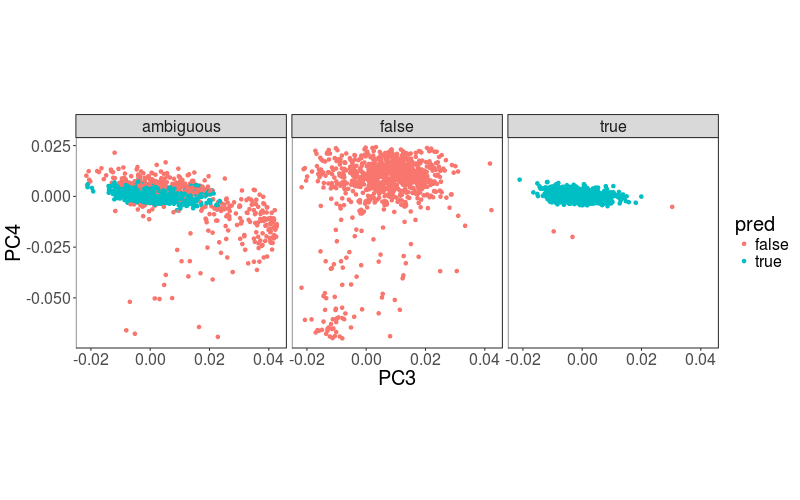

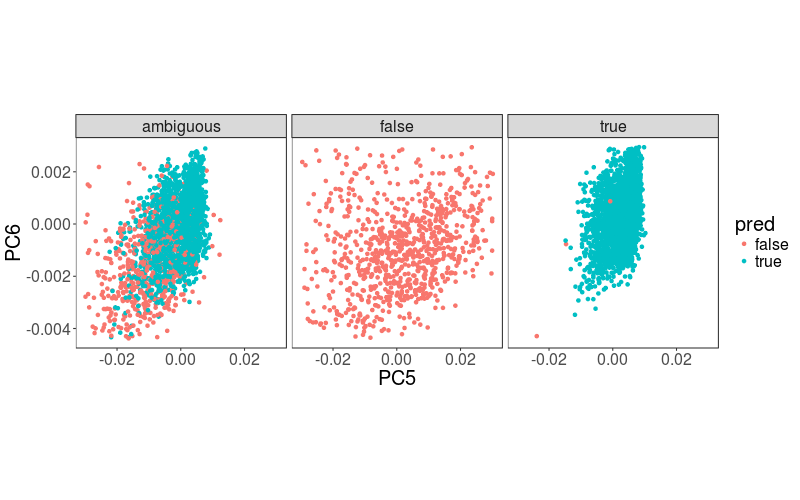

In [148]:
%%R -w 800 -h 500
printPCs(projections, colour_by="pred", facet_by="cell_type")

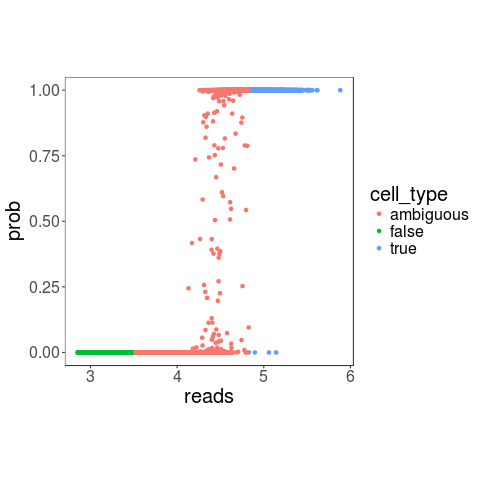

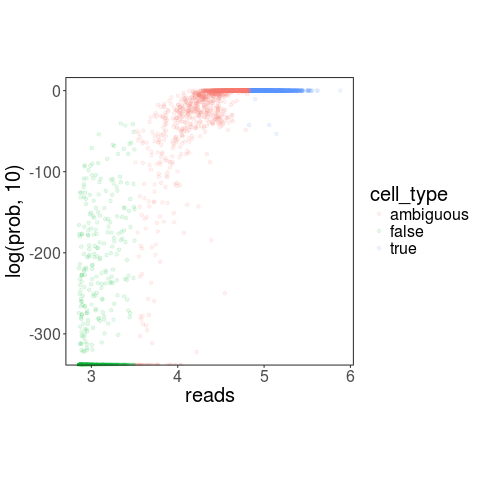

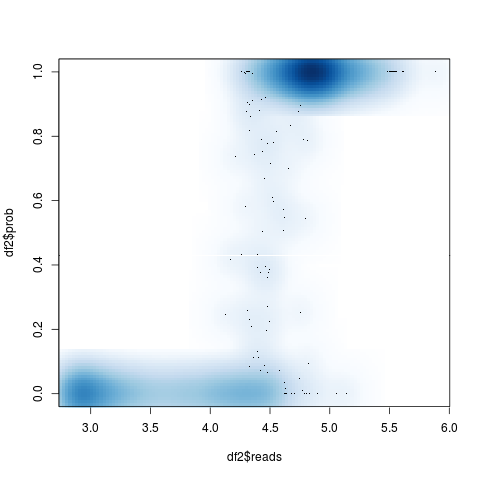

In [150]:
%%R
library(reshape2)
df2 = features
df2$reads = log(df2$cb_counts,10)

p <- ggplot(df2, aes(reads, prob, colour=cell_type)) +
geom_point() + my_theme
print(p)

p <- ggplot(df2, aes(reads, log(prob,10), colour=cell_type)) +
geom_point(alpha=0.1) + my_theme
print(p)

smoothScatter(df2$reads, df2$prob)